# Information Warfare: Russia’s use of Twitter during the 2016 US Presidential Election 

### Analysis by Ben Forleo

### Part 1

#### Background and research question

On January 7, 2017 the Office of the Director of National Intelligence released a declassified report detailing a Russian campaign to influence the 2016 election.  The report described a broad range of activities aimed at denigrating Secretary Hillary Clinton and undermining faith in the US democratic process. One facet of this campaign involved social media “trolls” employed by the Internet Research Agency, an organization financed by a close Putin ally with ties to Russian intelligence.  In an indictment of the Internet Research Agency dated February 16, 2018, special counsel Robert Mueller III accused this organization of attempting to sow discord online by posting derogatory and false information with an intent to interfere in the US 2016 election.

On August 27, 2018, the data journalism organization FiveThirtyEight published 2,973,371 tweets from accounts identified by Twitter as being associated with the Internet Research Agency. The dataset is the product of work done by Clemson Univeristy Professors Darren Linville and Patrick Warren who collected the data from Clemson University's Social Media Listening center. The researchers also classifed accounts according to their language and behavior: categories include Right Troll, Left Troll, News Feed, Hashtag Gamer, and Fearmonger. 

In a [working paper](http://pwarren.people.clemson.edu/Linvill_Warren_TrollFactory.pdf) describing their work, Linville and Warren discuss the qualitiative procedure that they employed to label accounts.

The purpose of this project is to test whether Linville and Warren's account categorization scheme can be replicated quanitatively using unsupervised learning techniques.


#### Procedure

The procedure that I will employ is as follows:

- Clean and tokenize text using the spaCy library
- Create vectorized representations of tweets using the doc2vec algorithm and the gensim library
- Cluster the vector representation of tweets using KMeans and Gaussian mixture models. 
- Assign an account to a particular cluster based on how tweets were clustered. If a majority of an accounts tweets appeared in cluster A, label that account as being part of cluster A. 
- Compare the results of this algorithmic labeling scheme with the labels assigned by Linville and Warren.

I will also attempt to create predictive modes that map the tweet vectors to both Linville and Warren's labels, as well as the clusters inferred through KMeans and GMM. 

Let's import some data!

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

import spacy
import os
import pickle

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

df = pd.read_pickle('/Users/benjaminforleo/disinformation_project_data/labeled_tweets.pkl')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

As always, we need to perform some EDA to get a sense of what's in our datset. Since I don't speak Russian, I will filter to include only English tweets. 

In [3]:
# Filter to include only English Tweets
df = df[df.language == "English"]

print("Shape: ", df.shape, "\n", "\n"
     "# Unique accounts: ", len(set(df.author)), "\n", "\n",
     "Account Type: ", list(set(df.account_type)), "\n", "\n",
     "Account Category: ", list(set(df.account_category)))

Shape:  (2116867, 21) 
 
# Unique accounts:  2161 
 
 Account Type:  ['German', 'Portuguese', 'Italian', 'Right', 'Hashtager', 'French', 'news', 'local', 'ZAPOROSHIA', 'Commercial', 'Left', 'Spanish', 'Koch', 'Russian', 'Arabic', '?', 'Ebola '] 
 
 Account Category:  ['NonEnglish', 'Unknown', 'Commercial', 'LeftTroll', 'NewsFeed', 'HashtagGamer', 'RightTroll', 'Fearmonger']


There are two sets of labels that Linville and Warren have created, namely, account type and account name. Account type consists of more granular labels, while account category is more broad. For this exercise, I will focus on the account category set of labels. 

Before we move on, I should point out that the labeling scheme employed by Linville and Warren allows for accounts that primarily tweet in English to be labeled as Non English. For example, an account that primarily tweets about international events, such as the war in Ukraine, would be labeled as Non English, even if the text is in English. The graph below indicates that accounts characterized by this behavior are limited. 

{'LeftTroll': 414862, 'HashtagGamer': 230642, 'RightTroll': 675323, 'NewsFeed': 595900, 'NonEnglish': 3769, 'Unknown': 1415, 'Commercial': 112243}


<Figure size 432x288 with 0 Axes>

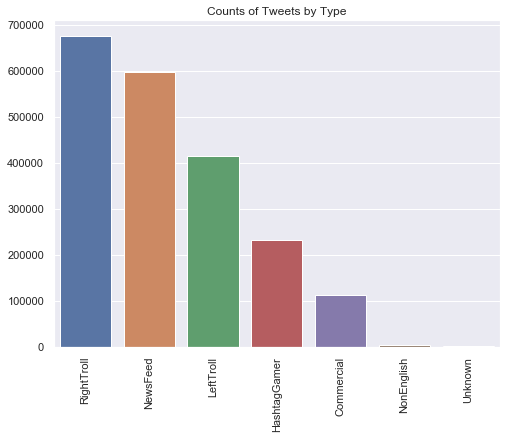

In [197]:
counts_by_type = dict(Counter(df.account_category))

print(counts_by_type)

account_type = list(counts_by_type.keys())
values = list(counts_by_type.values())

account_type = [x for _,x in sorted(zip(values ,account_type), reverse = True)]
values = sorted(values, reverse = True)

plt.clf()
plt.figure(figsize = (8,6))
sns.barplot(account_type, values)
plt.xticks(rotation = 'vertical')
plt.title('Counts of Tweets by Type')
plt.show()

The previous chart displayed information for overall tweets. However, what we are really interested in is activity per account. That is, it would be nice to know how many right trolls are in the dataset vs. left trolls and so on. Let's go ahead and visualize this information now. 

<Figure size 432x288 with 0 Axes>

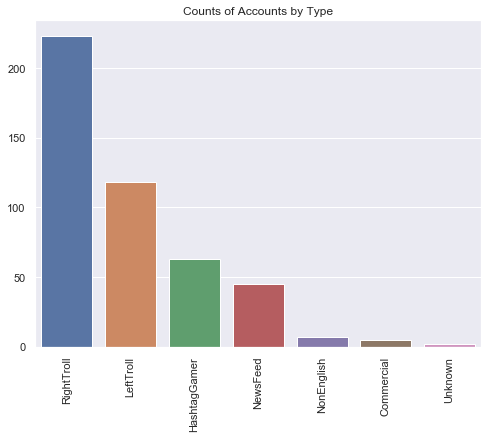

In [195]:
account_analysis = df.groupby(['author', 'account_category'])['content'].count().reset_index()

account_analysis = Counter(account_analysis.account_category)

account_type = list(account_analysis.keys())
values = list(account_analysis.values())

account_type = [x for _,x in sorted(zip(values ,account_type), reverse = True)]
values = sorted(values, reverse = True)

plt.clf()
plt.figure(figsize = (8,6))
sns.barplot(account_type, values)
plt.xticks(rotation = 'vertical')
plt.title('Counts of Accounts by Type')
plt.show()

Ok, this is a strange result. While Non English tweets account for very little of the overall tweet volume, there is a sizable number of Non English accounts in the dataset. 

For our procedure to work, we need to make sure that we have enough information (tweets) for each account for doc2vec to appropriatly embed our text in a vector space. As such, we need to ensure that we only consider accounts that meet some threshold for a minimum number of tweets, which we we do below. 

In [7]:
# Let's get counts of the number of tweets by each author
counts_by_author = df[['author', 'content']].groupby('author').count()

counts_by_author.reset_index(inplace = True)

print(sum(counts_by_author.content > 400))

author_series = counts_by_author.author[counts_by_author.content > 400]

df = df[df.author.isin(author_series)]

463


It should be noted that the choice of 400 tweets is arbitrary. Notice that by setting this threshold, the amount of Non English accounts in the dataset has decreased considerably. 

<Figure size 432x288 with 0 Axes>

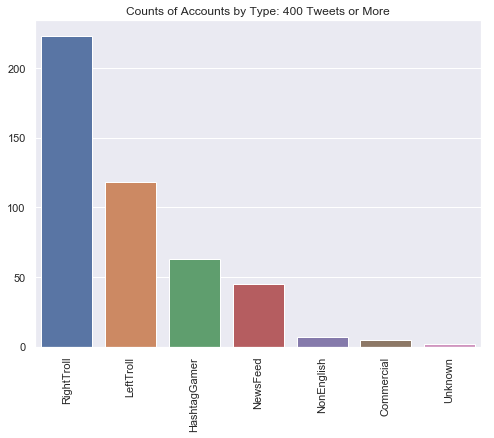

In [196]:
account_analysis = df.groupby(['author', 'account_category'])['content'].count().reset_index()
account_analysis = Counter(account_analysis.account_category)

account_type = list(account_analysis.keys())
values = list(account_analysis.values())

account_type = [x for _,x in sorted(zip(values ,account_type), reverse = True)]
values = sorted(values, reverse = True)

plt.clf()
plt.figure(figsize = (8,6))
sns.barplot(account_type, values)
plt.xticks(rotation = 'vertical')
plt.title('Counts of Accounts by Type: 400 Tweets or More')
plt.show()

# Sampling and Pre-Processing

As you may know, natural language processing can be computationally expensive. Since we are dealing with a large number of tweets, it makes sense to take a sample of the data that we want to work with. 

Here, I take a 30% sample from each account. 

Note: the 30% sample size is arbitrary.

In [9]:
df.content = df.content.astype(str)

# Create the groupby object of author and category. Note: every author is assigned one category
df_sampled = df.groupby(['author', 'account_category'])['content']

# Take a 30% sample from each group
df_sampled = df_sampled.apply(lambda x: x.sample(frac=0.3, replace = False)).reset_index()

You might be inclined to ask: why take a sample per account rather than just a sample of the overall dataset? When I first began expirimenting with this data, I tried to embed each individual tweet in a vector space. However, this procedure produced nonsensical results. It seems that there is not enough information contained in an individual tweet for us to gleen any useful unsights about the author, or discriminate between authors. 

However, if we were to combine tweets per author such that we have a single document for each author that is representative of everything that a particular author has ever tweeted, we will have more than enough information to give doc2vec a chance to work. 

There is just one problem: spaCy breaks if we try to parse long documents of text. As such, we will need to group our tweets by author after running the data through spaCy. 

Before we get to spaCy, we need to do some minor preprocessing. Here, I remove hyperlinks and and strip redundant whitepace from the text. I also expirimented with removing the RT symbol, but this did not seem to have any meaningful impact on our analysis. 

In [10]:
# SAMPLE AND PRE-CLEANING

# REMOVE RT SYMBOL
#from processing_functions import rt_remover
#df_sampled.content = df_sampled.content.apply(rt_remover)

# REMOVE ANY HYPERLINKS
from processing_functions import link_remover
df_sampled.content = df_sampled.content.apply(link_remover)


# STRIP ANY WHITESPACE ON EITHER SIDE OF THE TEXT
df_sampled.content = df_sampled.content.str.strip()

Now that we have done some basic pre-processing, we can begin to parse and clean our text with spaCy.

# Tokenization, cleaning, and lemmatization with spaCy

- Note: this takes approximately 5 - 10 minutes to run.

In [11]:
from spacy.tokens import Token

# This allows us to add custom attributes to tokens, in this case, hashtags and accounts
Token.set_extension('is_hashtag', default = False, force = True)
Token.set_extension('is_account', default = False, force = True)

# These functions tell spaCy what should be considered a hashtage or account
from processing_functions import hashtag_pipe
from processing_functions import is_account_pipe

# We can  disable pipeline objects to save time: disable = ['parser', 'etc']
nlp = spacy.load("en", disable = ['parser', 'ner'])

# Here I add the two custom functions for hashtags and accounts to the pipeline
nlp.add_pipe(hashtag_pipe)
nlp.add_pipe(is_account_pipe)

# And we're off!
parsed_tweets = list(nlp.pipe(df_sampled.content))

# Gensim


Before we train our gensim doc2vec model, we need to do some more cleaning. The clean_doc function is located in the processing_functions.py file in this repository. 

In [12]:
from processing_functions import clean_doc
lemma = list(map(clean_doc, parsed_tweets))

The next step is perhaps the most critical to this analysis. We need to group the parsed and cleaned tweets by author, so that for each author, we have a 30% sample of everything that they have ever tweeted in a single list (as discussed above). We can easily do this by applying our own function to a Pandas groupby object. 

In [13]:
# each row in parsed content is a list of lists
df_sampled['parsed_content'] = lemma

# lets flatten these so that each row only has one list
from processing_functions import group_lists
        
df_grouped = df_sampled.groupby(['author', 
                    'account_category'])['parsed_content'].apply(group_lists).reset_index()

# Convert the parsed content Series to a list for gensim
parsed_content = list(df_grouped.parsed_content)


Now that out data is clean and in the proper format, we can go ahead and create our gensim doc2vec model. It never ceases to amaze me that we can implement such a poweful algorithm in just a few lines of code. 

In [14]:
# create a doc2vec model
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# parsed_content is the list of parsed text
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(parsed_content)]

# Vector size of 300
model = Doc2Vec(documents, vector_size=300, window=5, min_count=3, workers=6)

arr_list = []

for index in range(0, len(model.docvecs)):
    arr_list.append(model.docvecs[index])
    
vec_array = np.stack(arr_list)

# Visualization and clustering

Great! We've cleaned, tokenized, and embeded our textual data in a vector space. Let's try to visualize our data and see where we are at. 

Since we are now working with a 300 dimension dataset, we need to employ a dimension reduction technique if we want to visualize some of the patterns in our data. t-SNE is a great algorithm for this purpose, and we will employ this technique in the space below. 

By reducing the number of dimensions with t-SNE, we can visualize our data on a two-dimensional canvas. In the following chart the color of each individual datapoint will correspond to a label manually assigned by Professors Warren and Linville. 

<Figure size 432x288 with 0 Axes>

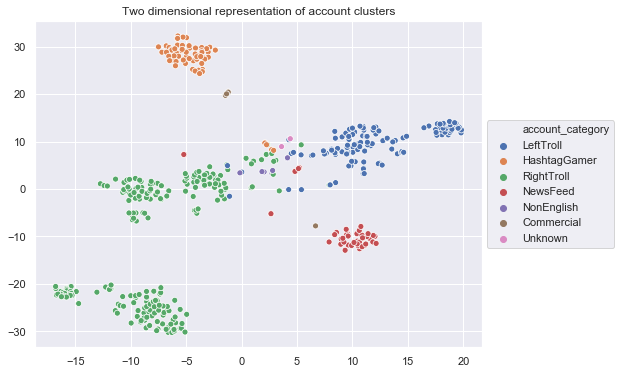

In [194]:
# Instantiate and fit the t-SNE model.
from sklearn.manifold import TSNE
tsne_35 = TSNE(n_components = 2, perplexity = 35, verbose = 0 , n_iter = 1000).fit_transform(vec_array)

plt.clf()
plt.figure(figsize = (8,6))
sns.scatterplot(x = tsne_35[:,0], y = tsne_35[:, 1], hue = df_grouped.account_category)
plt.title("Two dimensional representation of account clusters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Amazing! Our accounts seperate into distinct clusters that are more or less in line with the labels assigned by Warren and Linville! This suggests that we will be able to use KMeans or GMM to cluster accounts in an unsupervised way. 

One particularly interesting result is that there appears to be two distinct groups of Right Trolls that Warren and Linville did not seperate. By analyzing the behavior of these groups and others, we may be able to gain additional insight into Russian tradecraft and the overall objective of the Russian Twitter campaign.

Let's move on to our clustering algorithms!

### Kmeans

One of the challenges of using KMeans or any clustering algorithms is how to choose an appropriate K. We can use a metric called inertia to help aid us in choosing how many clusters we should specify for our data. 

But what is inertia and how does it work? Inertia is essentially a measure of clustering quality. That is, good clustering has tight clusters, and samples in each cluster are bunched together. Inertia measures how spread out clusters are and uses the distance from each sample to the centroid of its cluster in its calculation. 

A good rule of thumb is to choose the "elbow" in the inertia plot, or the inflection point where inertia begins to decrease at a slower rate.

Special shout-out to Hugo from Datacamp for teaching me about how inertia can be used to choose k, as well as laying the foundation for nearly everything that I know in python.

In [16]:
from sklearn.cluster import KMeans

inertias = []
clusters = list(range(1,11))

for k in clusters:
    
    model = KMeans(n_clusters = k)
    
    model.fit(vec_array)
    
    inertias.append(model.inertia_)

<Figure size 432x288 with 0 Axes>

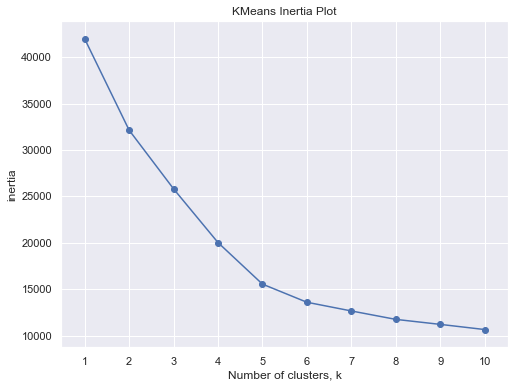

In [193]:
plt.clf()
plt.figure(figsize = (8,6))

plt.plot(clusters, inertias)
plt.scatter(clusters, inertias)
plt.xlabel('Number of clusters, k')
plt.ylabel('inertia')
plt.xticks(list(range(1,11)), list(range(1,11)))
plt.title("KMeans Inertia Plot")

plt.show()

The inertia plot suggests that a k of five may be appropriate for our data. Let's go ahead and instantiate a KMeans model with k equal to five.

In [61]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)

kmeans_labels = kmeans.fit_predict(vec_array)

<Figure size 432x288 with 0 Axes>

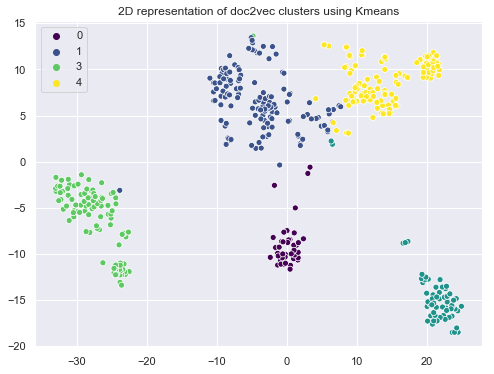

In [192]:
plt.clf()
plt.figure(figsize = (8,6))
sns.scatterplot(tsne_35[:,0], y = tsne_35[:, 1], hue= kmeans_labels, palette = 'viridis')
plt.title('2D representation of doc2vec clusters using Kmeans')

plt.show()

That looks great! I am actually surprised at how well KMeans seems to be performing on our data. 

KMeans is a discriminative algorithm, and can be thought of as a hard clustering technique. That is, a single element can only be assigned to one cluster. This may be problematic when analyzing text, as we are likely to see overlap between clusters and would naturally expect more ambiguity in our cluster assignments. For example, the ideological bent of a particular twitter acount may be unclear, and it may be difficult to place into one category or another based on the text alone. 

To account for uncertainty in cluster assignments, we could turn to a soft clustering method where we account for uncertainty in class assignment. For example, Gaussian Mixture Models (GMMs) are generative algorithms that provide a probabilistic way of doing soft clustering. 

GMMs can loosly be thought of as an extension of KMeans, except that instead of placeing centroids in random locations in space, we place probability distributions. We then use the Expectation Maximiazation algorithm to discover parameters for each probability distribution for our K sources, and move the distributions around until convergence.

GMMs allow us to calculate the probability that a sample belongs to a cluster. As such, each sample is assigned a probability that it belongs in each cluster. 

Let's go ahead and experiment with mixture models in the space below!

# Gaussian Mixture Models (Work in Progress)

I will be using Gaussian Mixture Models in the space below, although it is possible to use different kinds of probability distirbutions in mixture models. 

In [54]:
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=5).fit(vec_array)

gmm_labels = gmm.predict(vec_array)

<Figure size 432x288 with 0 Axes>

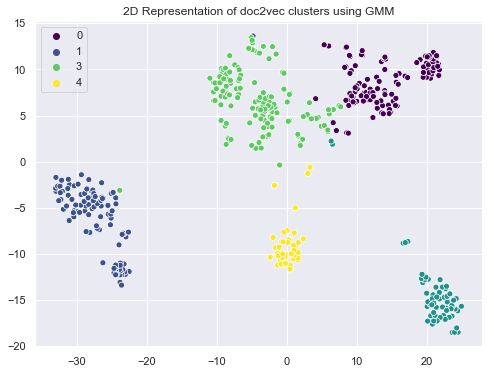

In [191]:
plt.clf()
plt.figure(figsize = (8,6))
sns.scatterplot(tsne_35[:,0], tsne_35[:, 1], hue = labels, palette = 'viridis')
plt.title('2D Representation of doc2vec clusters using GMM')
plt.show()

n_components associated with minimum AIC:  5


<Figure size 432x288 with 0 Axes>

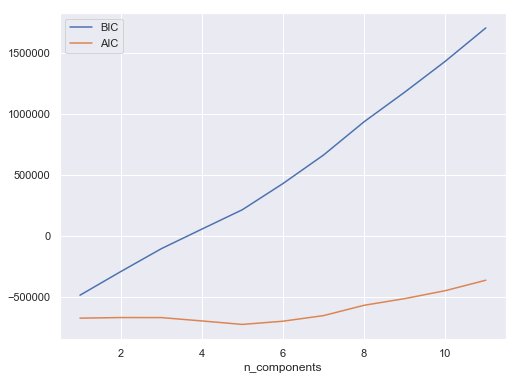

In [190]:
n_components = np.arange(1, 12)
models = [GMM(n, covariance_type='full', random_state=0).fit(vec_array)
          for n in n_components]
plt.clf()
plt.figure(figsize = (8,6))
sns.lineplot(n_components, [m.bic(vec_array) for m in models], label='BIC')
sns.lineplot(n_components, [m.aic(vec_array) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

print('n_components associated with minimum AIC: ', 
      np.argmin([m.aic(vec_array) for m in models]) + 1)

Weird. I'm getting some results that I didn't expect, particularly how that class labels looks exactly the same as those from KMeans, and how the AIC/BIC chart looks. I will be sticking with KMeasn for now, until I get a better understanding of how GMMs work. 

# Analysis

Now that we have completed our KMeans cluster assignments, it's time to see how they stack up against  Linville and Warrens labeling scheme.

In [81]:
df_grouped['kmeans_labels'] = kmeans_labels

df_grouped.head()

,author,account_category,parsed_content,kmeans_labels
0,4MYSQUAD,LeftTroll,"[@deray, #BlackLivesMatter, unarmed, d.c., dru...",4
1,AANTIRACIST,LeftTroll,"[#BlackHistory, be, my, canada, #LeafsBySnoop,...",4
2,ABIGAILSSILK,HashtagGamer,"[hello, i, be, @realDonaldTrump, go, hell, #Tr...",2
3,ABIISSROSB,RightTroll,"[#abi, break, charlottesville, death, count, i...",3
4,ABMERRLINS,RightTroll,"[popular, female, hunter, commits, suicide, af...",3


In [82]:
label_dict = {}

for row in df_grouped.iterrows():
    
    try: 
        label_dict[row[1].account_category].append(row[1].kmeans_labels)
    
    except:
        label_dict[row[1].account_category] = [row[1].kmeans_labels]

I want to compute the conditional probability of a cluster label given the label assigned by Linville and Warren. This is trickier than it seems, and I could not think of a better way to do this. 

In [137]:
choices = [0, 1, 2, 3, 4]

prob_df = pd.DataFrame()

for i in label_dict.keys():
    count = dict(Counter(label_dict[i]))
    length = sum(list(count.values()))

    prob_dict = {}

    for key in choices:
        try:
            prob_dict[key]= count[key]/length
        
        except:
            prob_dict[key]= 0
    
    row = pd.DataFrame(pd.Series(prob_dict)).T
    
    row.index = [i]
    
    prob_df = pd.concat([prob_df, row])

That was a lot of work!  We now have a dataframe of conditional probabilities. That is given a label by Warren and Linville, we have a conditional probability for each KMeans cluster label.  This is more clear if we view the dataframe. 

In [138]:
prob_df

,0,1,2,3,4
LeftTroll,0.000000,0.084746,0.000000,0.000000,0.915254
HashtagGamer,0.000000,0.031746,0.968254,0.000000,0.000000
RightTroll,0.000000,0.529148,0.000000,0.466368,0.004484
NewsFeed,0.911111,0.088889,0.000000,0.000000,0.000000
NonEnglish,0.000000,0.857143,0.000000,0.000000,0.142857
Commercial,0.200000,0.000000,0.800000,0.000000,0.000000
Unknown,0.000000,0.000000,0.000000,0.000000,1.000000


The table above indicates that for the most part, our clusters align pretty well with Warren and Linville's labels. Let's go ahead and visualize this. 

<Figure size 432x288 with 0 Axes>

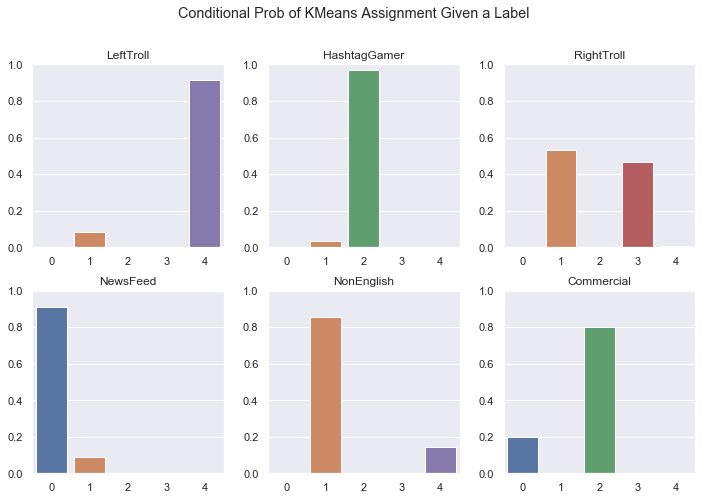

In [169]:
prob_df_t = prob_df.T

plt.clf()
plt.figure(figsize = (10,10))
plt.suptitle('Conditional Prob of KMeans Assignment Given a Label')

for idx, label in enumerate(list(prob_df_t.columns)[:6]):
    plt.subplot(3,3, idx +1)
    plt.ylim(0,1)
    sns.barplot(x = list(prob_df_t.index), y = list(prob_df_t[label]))
    plt.title(label)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [176]:
df_sampled = df_sampled.merge(df_grouped[['author', 'kmeans_labels']], 
                 left_on = 'author', right_on = 'author')

# Modeling